In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

# Testbench parameters

The small-scale maritime thruster testbench was modelled using the shaft-line finite element method (FEM). In the shaft-line FEM, the system is modelled as lumped-elements with inertia, connected by torsional springs with stiffness and damping. Torque losses from the motors and gears were modelled as external damping.

In [3]:
def new_parameters():
    inertias = np.array([7.94e-4,
                         3.79e-6,
                         3.00e-6,
                         2.00e-6,
                         7.81e-3,
                         2.00e-6,
                         (3.17e-6 - 7800*(np.pi*(0.006**4)/32)*0.342/6) + 7800*(np.pi*(0.008**4)/32)*0.342/6,
                         5.01e-5,
                         6.50e-6,
                         5.65e-5,
                         4.27e-6,
                         3.25e-4,
                         1.20e-4,
                         1.15e-5,
                         1.32e-4,
                         4.27e-6,
                         2.69e-4,
                         1.80e-4,
                         2.00e-5,
                         2.00e-4,
                         4.27e-6,
                         4.95e-2])

    stiffnesses = np.array([1.90e5,
                            6.95e3,
                            90.00,
                            90.00,
                            90.00,
                            90.00,
                            80e9*(np.pi*(0.008**4)/32)/0.342,
                            4.19e4,
                            5.40e3,
                            4.19e4,
                            1.22e3,
                            4.33e4,
                            3.10e4,
                            1.14e3,
                            3.10e4,
                            1.22e4,
                            4.43e4,
                            1.38e5,
                            2.00e4,
                            1.38e5,
                            1.22e4])

    damping = np.array([8.08,
                        0.29,
                        0.24,
                        0.24,
                        0.24,
                        0.24,
                        0.00,
                        1.78,
                        0.23,
                        1.78,
                        0.52,
                        1.84,
                        1.32,
                        0.05,
                        1.32,
                        0.52,
                        1.88,
                        5.86,
                        0.85,
                        5.86,
                        0.52])


    external_damping = np.array([0.0030,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.2400])

    gear_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1, 1, 1, 1, 1/4, 1, 1, 1, 1])

    return inertias, stiffnesses, damping, external_damping, gear_ratios


# State-space matrices

The state-space matrices are constructed the same way as in the master's thesis and the MSSP article.

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios, full_B=False):
    """
    Parameters:
    
    inertia : list
        The inertia values of each lumped mass in order from index 1...n
    stiff : list
        The stiffness values between each lumped mass in order from index 1...n
    damp : list
        The viscous damping values between each lumped mass in order from index 1...n
    damp_ext : list
        The external damping corresponding to torque losses from the motors and gears
    ratios : list
        The gear ratios between each lumped mass
    full_B : bool
        If true, the input matrix B is shape n x p, allowing applying an input at the
        location of every lumped mass. By default it's shape is n x 2, for applying an input
        at the locations corresponding to the driving motor and the propeller. 
        
    Returns:
    
    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    D : numpy.ndarray
        The feedthrough matrix, always a zero matrix

    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)

    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)

    ks = -np.hstack((stiff*ratios, 0))
    A12 = np.delete(
        (np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1
    )


    A23 = np.delete(
        np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0
    )

    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))

    if full_B:
        B = np.zeros(A.shape)
        for i in range(len(inertia)):
            B[i,i] += 1/inertia[i]
    else:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[len(inertia)-1, 1] -= 1/inertia[-1]

    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))

    return A, B, C, D

In [5]:
def c2d(A, B, ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time ts.
    The function returns matrices Ad, Bd of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]

    return Ad, Bd


# Data equation matrices

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))

    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O


def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)

    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B,
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z

        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))

        # then add the impulse responses
        A_power2 = np.copy(A)

        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))

        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))

        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1

    return gamma


def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2


# Simulated unit excitations

The same simulated unit excitations as in the master's thesis.

In [7]:
# parameters for simulated excitations
fs = 1000  # sampling frequency
t_sim = np.arange(0,10,1/fs)  # timesteps
dt_sim = np.mean(np.diff(t_sim))  # timestep length

In [8]:
def impulse_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_imp : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """
    U_imp = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .1, U_imp.shape[0])
    e2 = np.random.normal(0, .1, U_imp.shape[0])

    one_hit = np.hstack((np.linspace(0, 0.34, 7), np.linspace(0.38, 0.64, 7), np.linspace(0.67, 0.87, 7), np.linspace(0.9, 0.98, 7)))

    U_imp[:,0] += 2.7 + e1
    U_imp[:,1] += e2
    U_imp[3200:3228,1] += one_hit*10
    U_imp[3228:3228+28,1] += np.flip(one_hit*10)
    U_imp[5200:5228,1] += one_hit*10
    U_imp[5228:5228+28,1] += np.flip(one_hit*10)
    U_imp[8200:8228,1] += one_hit*10
    U_imp[8228:8228+28,1] += np.flip(one_hit*10)

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_imp[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_imp[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_imp

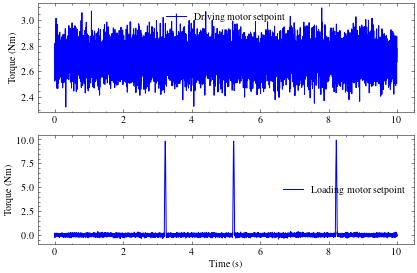

In [9]:
impulse_sim = impulse_excitation(t_sim, plot=True)

In [10]:
def step_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_step : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """
    U_step = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .1, U_step.shape[0])
    e2 = np.random.normal(0, .1, U_step.shape[0])

    # U_step[:,0] += np.flip(np.linspace(-2.5, 2.5, 10000)) + e1
    U_step[:,0] += 2.7 + e1
    U_step[:,1] += e2
    U_step[3200:5200,1] += 10.0
    U_step[5200:8200,1] -= 4.0
    U_step[8200:,1] += 0.5

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_step[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_step[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_step

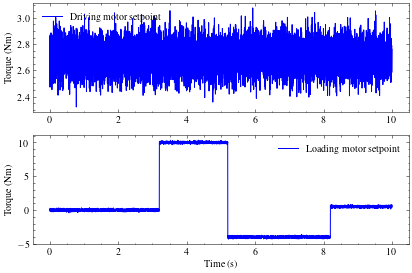

In [11]:
step_sim = step_excitation(t_sim, plot=True)

In [12]:
def sinusoidal_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_sin : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """

    def sum_sines(freqs, amps, phases, times, dc_offset):
        """
        Generates a sinusoidal signal that is a sum of three sine waves with different frequencies.

        Args:
        freqs (list[float]): List of three frequencies for the sine waves.
        amps (list[float]): List of three amplitudes for the sine waves.
        phases (list[float]): List of three phase shifts for the sine waves.
        times (numpy.ndarray): Timesteps of the signal in seconds.

        Returns:
        numpy.ndarray: Sinusoidal signal that is a sum of three sine waves.
        """

        signal = np.zeros(len(times))
        for f, a, p in zip(freqs, amps, phases):
            signal += a * np.sin(2 * np.pi * f * times + p)

        return signal + dc_offset

    freqs = [2000/60, 4*2000/60, 8*2000/60]
    amps = [10, 5, 1]
    phases = [0, 0, 0]
    offset = 10
    sine_signal = sum_sines(freqs, amps, phases, sim_times, offset)

    U_sin = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .1, U_sin.shape[0])
    e2 = np.random.normal(0, .1, U_sin.shape[0])

    U_sin[:,0] += 2.7 + e1
    U_sin[:,1] += sine_signal + e2

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_sin[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_sin[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_sin

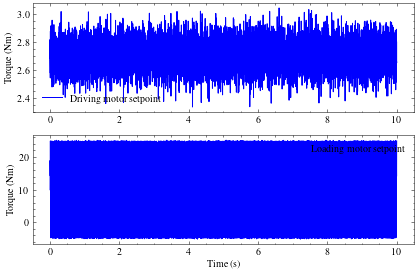

In [13]:
sin_sim = sinusoidal_excitation(t_sim, plot=True)

# Get excitation and measurement data

This dataset was used in the master's thesis for the excitation experiments on the testbench. Sampling frequency ~1 kHz. The data has been low pass filtered with a cutoff frequency of 500 Hz.

### No load test

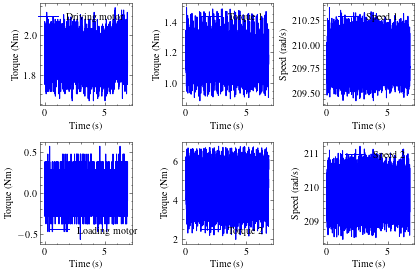

In [14]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_no = np.loadtxt("../data/masters_data/processed_data/no_load_2000_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_no = np.loadtxt("../data/masters_data/processed_data/no_load_2000_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_no[:,0], motor_data_no[:,2], label='Driving motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_no[:,0], motor_data_no[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_no[:,0], sensor_data_no[:,3], label='Torque 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_no[:,0], sensor_data_no[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_no[:,0], sensor_data_no[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_no[:,0], sensor_data_no[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

The testbench driving speed is kept constant 2000 rpm, loading motor torque is zero. By subtracting the mean of the measurement from the measurement, what is left is noise $r_n$ (and possible speed fluctuations, however, assumebd negilible for now). The measurement covariance matrix can be formed as follows:
$$ \text{Cov}(r_n) = E[r_n r_n^T]-E[r_n]E[r_n]^T = R $$

In [15]:
# TODO: try this with a section of the ice experiment, the torque transducer noise here seems too low
r1 = sensor_data_no[:,1] - np.mean(sensor_data_no[:,1])
r2 = sensor_data_no[:,2] - np.mean(sensor_data_no[:,2])
r3 = sensor_data_no[:,3] #- np.mean(sensor_data_no[:,3])

r1_cov = np.mean(r1**2) - np.mean(r1)**2
print(r1_cov)
r2_cov = np.mean(r2**2) - np.mean(r2)**2
print(r2_cov)
r3_cov = np.mean(r3**2) - np.mean(r3)**2
print(r3_cov)

0.027126295529787316
0.2184364241520009
0.012832272831375668


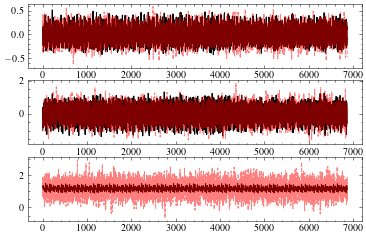

In [16]:
r1_sim = np.ones(len(sensor_data_no[:,1]))*np.mean(sensor_data_no[:,1]) + np.random.normal(0, 0.17, len(sensor_data_no[:,1]))
r1_sim -= np.mean(r1_sim)
r2_sim = np.ones(len(sensor_data_no[:,2]))*np.mean(sensor_data_no[:,2]) + np.random.normal(0, 0.47, len(sensor_data_no[:,2]))
r2_sim -= np.mean(r2_sim)
r3_sim = np.ones(len(sensor_data_no[:,3]))*np.mean(sensor_data_no[:,3]) + np.random.normal(0, 0.44, len(sensor_data_no[:,3]))
#r3_sim -= np.mean(r3_sim)

plt.subplot(311)
plt.plot(r1)
plt.plot(r1_sim, alpha=0.5)
plt.subplot(312)
plt.plot(r2)
plt.plot(r2_sim, alpha=0.5)
plt.subplot(313)
plt.plot(r3)
plt.plot(r3_sim, alpha=0.5)

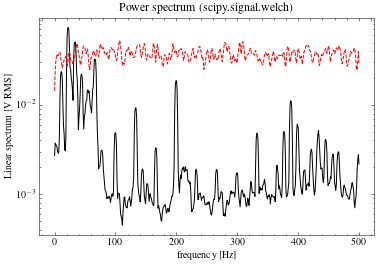

In [17]:
f, Pxx_spec = welch(r3, 1000, 'flattop', 1024, scaling='spectrum')
f2, Pxx_spec2 = welch(r3_sim, 1000, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.semilogy(f2, np.sqrt(Pxx_spec2))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.title('Power spectrum (scipy.signal.welch)')
plt.show()

### Unit excitations

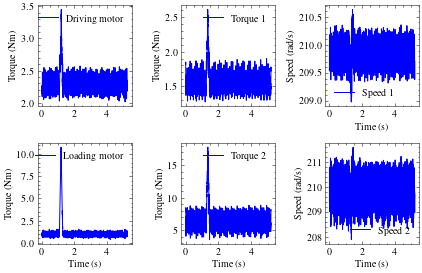

In [18]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

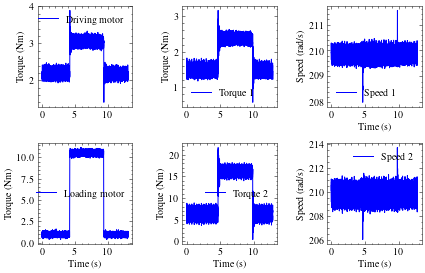

In [19]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("../data/masters_data/processed_data/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("../data/masters_data/processed_data/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

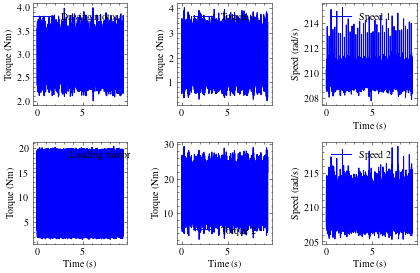

In [20]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_sin = np.loadtxt("../data/masters_data/processed_data/sin_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_sin = np.loadtxt("../data/masters_data/processed_data/sin_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_sin[:,0], motor_data_sin[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_sin[:,0], motor_data_sin[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_sensor.csv", delimiter=",")

In [22]:
time = sensor_data[:,0]
measurements = sensor_data[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data[:,2], motor_data[:,4])).T # motor torque data

In [23]:
motor_setpoint = motor_data[:,1]
propeller_setpoint = motor_data[:,3]

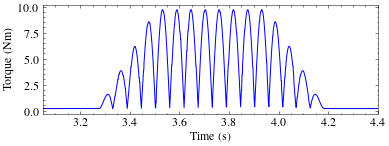

In [24]:
plt.figure(figsize=(6,2))
plt.plot(time, propeller_setpoint, c='b')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Torque (Nm)', fontsize=12)
plt.xlim(3.05,4.4)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("notebook_figures/propeller_setpoint1.eps")

In [25]:
motor = motors[:,0]
propeller = motors[:,-1]

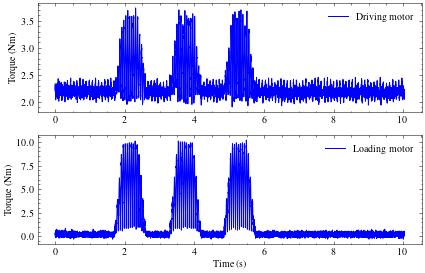

In [26]:
plt.subplot(211)
plt.plot(time, motor, label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(212)
plt.plot(time, propeller, label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()

plt.show()

# Initiate the input and state estimation procedure

In [27]:
def get_testbench_state_space(dt):
    """
    This function returns the discrete-time state-space matrices of the testbench model.
    """
    inertias, stiffs, damps, damps_ext, ratios = new_parameters()
    Ac, Bc, C, D = state_space_matrices(inertias, stiffs, damps, damps_ext, ratios)

    A, B = c2d(Ac, Bc, dt)

    return A, B, C, D

In [28]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [29]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

# Analytical solution of the $\ell_2$ regularized LS problem

In [30]:
def progressbar(it, prefix="", size=60, out=sys.stdout, show_print=False):
    """
    A function used to display a progress bar in the console.
    """
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    if show_print:
        print("\n", flush=True, file=out)

In [31]:
def get_data_equation_matrices(A, B, C, D, n, bs):
    D2 = second_difference_matrix(bs, B.shape[1])
    O_mat = O(A, C, bs)
    G = gamma(A, B, C, bs)
    L = np.eye(bs*B.shape[1])

    return O_mat, G, D2, L

In [32]:
def ell2_analytical(ss, measurements, batch_size, overlap, times, lam=0.1, use_trend_filter=False, print_bar=True):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint.
    """
    dt = np.mean(np.diff(times))
    n = len(times)
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    H = np.hstack([O_mat, G])  # extended observation and impulse response matrix
    M = np.hstack([np.zeros((regul_matrix.shape[0], O_mat.shape[1])), regul_matrix])  # extended regularization matrix
    
    input_estimates = []

    for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len, show_print=print_bar):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        estimate = LA.inv(H.T @ H + lam*(M.T @ M)) @ H.T @ y

        input_estimates.append(estimate)

    return input_estimates

In [33]:
def ell2_analytical_with_covariance(ss, measurements, batch_size, overlap, times, lam=0.1, use_trend_filter=False, print_bar=True):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint and known covariance for input and output.
    Initial state is always assumed zero.
    """
    dt = np.mean(np.diff(times))
    n = len(times)
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    # measurement noise covariance matrix
    R = np.diag([0.05, 0.10, 0.20])
    #R = np.diag([0.03, 0.20, 0.01])
    R_inv = LA.inv(R)
    I = np.eye(bs)
    # measurement noise covariance assembled as a diagonal block matrix
    WR = np.kron(I, R_inv)
    
    input_estimates = []

    for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len, show_print=print_bar):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        #estimate = LA.inv(H.T @ H + lam*(M.T @ M)) @ H.T @ y
        estimate = LA.inv(G.T @ WR @ G + lam*(regul_matrix.T@regul_matrix)) @ G.T @ WR @ y

        input_estimates.append(estimate)

    return input_estimates

# L-curve using the simulated impulse excitation

The L-curve calculated using $ u = \left( \Gamma^T \Gamma + \lambda L^TL \right)^{-1} \Gamma^T y $, and plotting the residual norm and the $\ell_2$-norm on a log-log plot.

In [34]:
def L_curve(ss, measurements, times, lambdas, use_trend=False):
    dt = np.mean(np.diff(times))
    batch_size = len(times)
    overlap = 0
    n = len(times)

    A, B, C, D = ss
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, batch_size)

    if use_trend:
        regularization = D2
    else:
        regularization = L

    input_estimates = []

    y = measurements.reshape(-1,1)

    for i in progressbar(range(len(lambdas)), "Calculating estimates :", len(lambdas)):
        estimates = LA.inv(G.T @ G + lambdas[i]*(regularization.T @ regularization)) @ G.T @ y
        input_estimates.append(estimates)

    norm, res_norm = [], []
    for i in range(len(lambdas)):
        res_norm.append(np.linalg.norm(y - G @ input_estimates[i]))
        norm.append(np.linalg.norm(regularization @ input_estimates[i]))

    return norm, res_norm, input_estimates

In [35]:
#def calculate_curvature(lambdas, l_norms, res_norms):
#    kappas = []
#    for i in range(len(lambdas)):
#        eta = l_norms[i]**2
#        rho = res_norms[i]**2
#        eta_dot = 
#        rho_dot = -lambdas[i]**2*eta_dot
#        k = 2*(eta*rho)/eta_dot * (lambdas[i]**2*eta_dot*rho+2*lambdas[i]*eta*rho+lambdas[i]**4*eta*eta_dot)/(lambdas[i]**2*eta**2+rho**2)**(3/2)
#        kappas.append(k)
    
#    return kappas

In [36]:
def calculate_L_curve(times, dt, load, lambdas, use_trend=False, show_plot=False):
    A, B, C, D = get_testbench_state_space(dt)
    sys = (A, B, C, D)

    tout, yout, _ = dlsim((A, B, C, D, dt), u=load, t=times)
    e3 = np.random.normal(0, .1, yout.shape)
    y_noise = yout + e3

    l_norm, residual_norm, input_estimates = L_curve(
        sys,
        y_noise,
        tout,
        lambdas,
        use_trend=use_trend
    )

    #plt.plot(input_estimates[6][1::2])
    #plt.show()
    
    if show_plot:
        plt.figure(figsize=(6,4))
        plt.yscale("log")
        plt.xscale("log")
        plt.plot(residual_norm, l_norm, color='blue')
        plt.scatter(residual_norm, l_norm, color='blue')
        plt.scatter(residual_norm[6], l_norm[6], color='red', zorder=10)
        plt.xlabel("Residual norm $||y-\Gamma \hat{u}||_2$", fontsize=12)
        plt.ylabel("Regularizing norm $||L \hat{u}||_2$", fontsize=12)
        plt.annotate(
            "$\lambda = $" + str(lambdas[3]),
            (residual_norm[3], l_norm[3]),
            (residual_norm[3]-0.6, l_norm[3]-5)
        )
        plt.annotate(
            "$\lambda = $" + str(lambdas[6]),
            (residual_norm[6], l_norm[6]),
            (residual_norm[6]-0.5, l_norm[6]-0.1)
        )
        plt.annotate(
            "$\lambda = $" + str(lambdas[9]),
            (residual_norm[9], l_norm[9]),
            (residual_norm[9], l_norm[9]+0.05)
        )
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        #plt.grid(which="both")
        #plt.tight_layout()
        plt.savefig("notebook_figures/impulse_hp_lcurve.eps")
        plt.show()

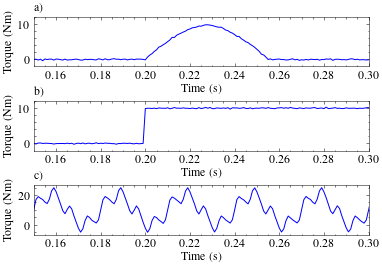

In [37]:
# taking a 500 timestep long section of the simulated excitation
excitation_sim = impulse_sim[3000:3500]
excitation_sim2 = step_sim[3000:3500]
excitation_sim3 = sin_sim[3000:3500]

plt.figure(figsize=(6,4))
t_sim_short = t_sim[:500]
plt.subplot(311)
plt.title("a)", loc='left', fontsize=12)
plt.plot(t_sim_short, excitation_sim[:,1], c='b')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0.15, 0.3)
plt.ylim(-2, 12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(312)
plt.title("b)", loc='left', fontsize=12)
plt.plot(t_sim_short, excitation_sim2[:,1], c='b')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0.15, 0.3)
plt.ylim(-2, 12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(313)
plt.title("c)", loc='left', fontsize=12)
plt.plot(t_sim_short, excitation_sim3[:,1], c='b')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0.15, 0.3)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplots_adjust(hspace=0.7)
plt.savefig("notebook_figures/simulated_unit_excitations.eps")

In [38]:
# Regularization parameters for the calculation of the L-curve
regularization_parameters = np.logspace(-6, 6, 13)
print("Lambda values: ", regularization_parameters)

Lambda values:  [      0.           0.           0.0001       0.001        0.01
       0.1          1.          10.         100.        1000.
   10000.      100000.     1000000.    ]


### Simulated impulse L-curve

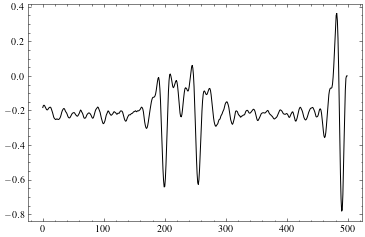

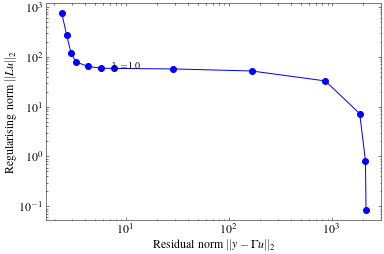

In [39]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim, regularization_parameters, use_trend=False, show_plot=True)

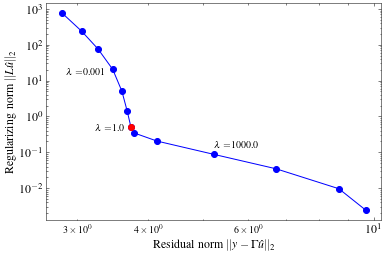

In [39]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim, regularization_parameters, use_trend=True, show_plot=True)

### Simulated step L-curve

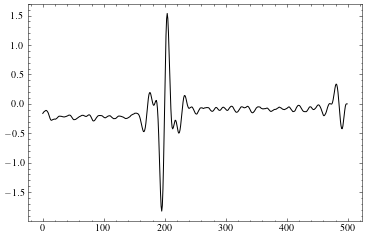

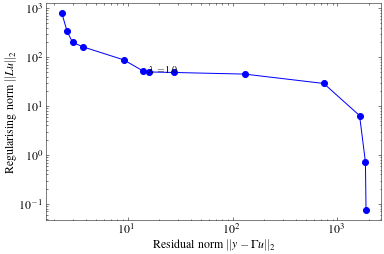

In [41]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim2, regularization_parameters, use_trend=False, show_plot=True)

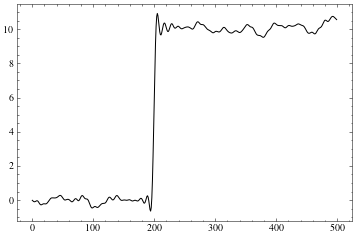

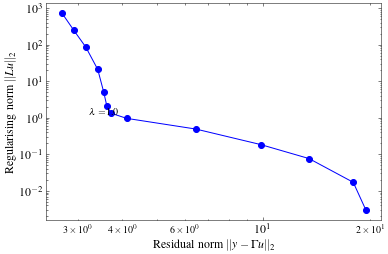

In [42]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim2, regularization_parameters, use_trend=True, show_plot=True)

### Simulated sin L-curve

Note: The L-curve criterion practically means choosing $\lambda$ at the corner of the L-curve as the regularization parameter. A mathematical definition for the corner exists, where the corner is found by calculating the curvature $\kappa$ of the L-curve. The pareto-optimal $\lambda$ is found where $\kappa$ is the largest. In this case, as is shown by the shape of the L-curve of the simulated sinusoidal excitation below, relying on $\kappa$ might not give the best value for $\lambda$.

In the present application, it might be beneficial to choose $\lambda$ qualitatively from the L-curve plot, especially as the user might want to utilize different values $\lambda$ to affect how strong the regularization is during torque estimation.

One option could be to first calculate a rough L-curve using a large range of values $\lambda$ and then concentrate on a smaller section of the L-curve, where the curvature $\kappa$ is calculated and a pareto-optimal $\lambda$ is found. However, whether solving a very precise value for $\lambda$ is necessary in this application is unclear.

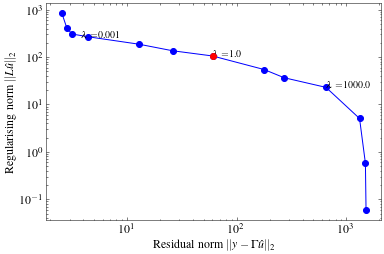

In [35]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim3, regularization_parameters, use_trend=False, show_plot=True)

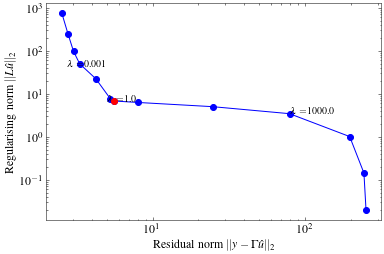

In [36]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim3, regularization_parameters, use_trend=True, show_plot=True)

In [38]:
# parameters for the input and state estimation
batch_size = 500
overlap = 100

In [39]:
# lambda values for the different excitations
lam_tikh_imp = 0.001 # 0.01
lam_hp_imp = 1 # 10
lam_tikh_step = 0.1
lam_hp_step = 1
lam_tikh_sin = 0.1
lam_hp_sin = 1
lam_tikh_ice = 0.1
lam_hp_ice = 1

### Simulated unit excitation estimation

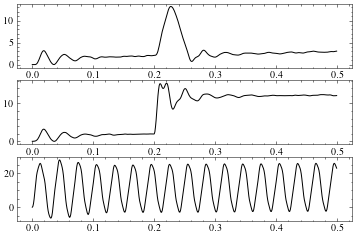

In [40]:
tout_sim_imp, yout_sim_imp, _ = dlsim((A, B, C_mod, D_mod, 1e-3), excitation_sim, t=t_sim_short)
tout_sim_step, yout_sim_step, _ = dlsim((A, B, C_mod, D_mod, 1e-3), excitation_sim2, t=t_sim_short)
tout_sim_sin, yout_sim_sin, _ = dlsim((A, B, C_mod, D_mod, 1e-3), excitation_sim3, t=t_sim_short)

plt.subplot(311)
plt.plot(tout_sim_imp, yout_sim_imp[:,-1])
plt.subplot(312)
plt.plot(tout_sim_step, yout_sim_step[:,-1])
plt.subplot(313)
plt.plot(tout_sim_sin, yout_sim_sin[:,-1])

In [41]:
# TIKHONOV IMPULSE
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_imp = yout_sim_imp[:,:-1] + np.random.normal(0, .1, yout_sim_imp[:,:-1].shape)
print(measurements_sim_imp.shape)
lam_imp = lam_tikh_imp
estimates_imp_sim_tikh = ell2_analytical(
    ss, measurements_sim_imp, batch_size, 0, t_sim_short, lam=lam_imp, use_trend_filter=False
)

(500, 3)
Calculating estimates: [█] 1/1



In [42]:
# HP IMPULSE
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
lam_imp = lam_hp_imp
estimates_imp_sim = ell2_analytical(
    ss, measurements_sim_imp, batch_size, 0, t_sim_short, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [█] 1/1



In [43]:
# HP IMPULSE with known covariance
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
lam_imp = lam_hp_imp
estimates_imp_sim_cov = ell2_analytical_with_covariance(
    ss, measurements_sim_imp, batch_size, 0, t_sim_short, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [█] 1/1



In [44]:
# TIKHONOV STEP
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_step = yout_sim_step[:,:-1] + np.random.normal(0, .1, yout_sim_step[:,:-1].shape)
print(measurements_sim_step.shape)
lam_step = lam_tikh_step
estimates_step_sim_tikh = ell2_analytical(
    ss, measurements_sim_step, batch_size, 0, t_sim_short, lam=lam_step, use_trend_filter=False
)

(500, 3)
Calculating estimates: [█] 1/1



In [45]:
# HP STEP
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
lam_step = lam_hp_step
estimates_step_sim = ell2_analytical(
    ss, measurements_sim_step, batch_size, 0, t_sim_short, lam=lam_step, use_trend_filter=True
)

Calculating estimates: [█] 1/1



In [46]:
# HP STEP with known covariance
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
lam_step = lam_hp_step
estimates_step_sim_cov = ell2_analytical_with_covariance(
    ss, measurements_sim_step, batch_size, 0, t_sim_short, lam=lam_step, use_trend_filter=True
)

Calculating estimates: [█] 1/1



In [47]:
# TIKHONOV SIN
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_sin = yout_sim_sin[:,:-1] + np.random.normal(0, .1, yout_sim_sin[:,:-1].shape)
print(measurements_sim_sin.shape)
lam_sin = lam_tikh_sin
estimates_sin_sim_tikh = ell2_analytical(
    ss, measurements_sim_sin, batch_size, 0, t_sim_short, lam=lam_sin, use_trend_filter=False
)

(500, 3)
Calculating estimates: [█] 1/1



In [48]:
# HP SIN
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_sin = yout_sim_sin[:,:-1] + np.random.normal(0, .1, yout_sim_sin[:,:-1].shape)
print(measurements_sim_sin.shape)
lam_sin = lam_hp_sin
estimates_sin_sim = ell2_analytical(
    ss, measurements_sim_sin, batch_size, 0, t_sim_short, lam=lam_sin, use_trend_filter=True
)

(500, 3)
Calculating estimates: [█] 1/1



In [49]:
# HP SIN with known covariance
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_sin = yout_sim_sin[:,:-1] + np.random.normal(0, .1, yout_sim_sin[:,:-1].shape)
print(measurements_sim_sin.shape)
lam_sin = lam_hp_sin
estimates_sin_sim_cov = ell2_analytical_with_covariance(
    ss, measurements_sim_sin, batch_size, 0, t_sim_short, lam=lam_sin, use_trend_filter=True
)

(500, 3)
Calculating estimates: [█] 1/1



In [50]:
def process_estimates(n_batches, overlap, estimates, nstates=43):
    """
    Here the input and initial state estimates are processed.
    Overlapped sections are discarded and the input estimate batches are stacked one after the other.
    """
    motor_estimates, propeller_estimates = [], []
    motor_est_overlap, prop_est_overlap = [], []
    for i in range(n_batches):
        if i == 0:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = all_motor_estimates[:-2*overlap]
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = all_propeller_estimates[:-2*overlap]
        else:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = np.concatenate(
                (motor_estimates, all_motor_estimates[overlap:-overlap])
            )
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = np.concatenate(
                (propeller_estimates, all_propeller_estimates[overlap:-overlap])
            )
    
    return motor_estimates, propeller_estimates

### Process and plot simulated shaft torque estimates

In [51]:
motor_estimates_imp_sim_tikh, propeller_estimates_imp_sim_tikh = estimates_imp_sim_tikh[0][43::2], estimates_imp_sim_tikh[0][44::2]
U_est_imp_sim_tikh = np.hstack((motor_estimates_imp_sim_tikh, propeller_estimates_imp_sim_tikh))
tout_imp_sim_tikh, yout_imp_sim_tikh, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_sim_tikh, t=t_sim_short)

In [52]:
motor_estimates_imp_sim, propeller_estimates_imp_sim = estimates_imp_sim[0][43::2], estimates_imp_sim[0][44::2]
U_est_imp_sim = np.hstack((motor_estimates_imp_sim, propeller_estimates_imp_sim))
tout_imp_sim, yout_imp_sim, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_sim, t=t_sim_short)

In [53]:
motor_estimates_imp_sim_cov, propeller_estimates_imp_sim_cov = estimates_imp_sim_cov[0][::2], estimates_imp_sim_cov[0][1::2]
U_est_imp_sim_cov = np.hstack((motor_estimates_imp_sim_cov, propeller_estimates_imp_sim_cov))
tout_imp_sim_cov, yout_imp_sim_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_sim_cov, t=t_sim_short)

In [54]:
motor_estimates_step_sim_tikh, propeller_estimates_step_sim_tikh = estimates_step_sim_tikh[0][43::2], estimates_step_sim_tikh[0][44::2]
U_est_step_sim_tikh = np.hstack((motor_estimates_step_sim_tikh, propeller_estimates_step_sim_tikh))
tout_step_sim_tikh, yout_step_sim_tikh, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step_sim_tikh, t=t_sim_short)

In [55]:
motor_estimates_step_sim, propeller_estimates_step_sim = estimates_step_sim[0][43::2], estimates_step_sim[0][44::2]
U_est_step_sim = np.hstack((motor_estimates_step_sim, propeller_estimates_step_sim))
tout_step_sim, yout_step_sim, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step_sim, t=t_sim_short)

In [56]:
motor_estimates_step_sim_cov, propeller_estimates_step_sim_cov = estimates_step_sim_cov[0][::2], estimates_step_sim_cov[0][1::2]
U_est_step_sim_cov = np.hstack((motor_estimates_step_sim_cov, propeller_estimates_step_sim_cov))
tout_step_sim_cov, yout_step_sim_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step_sim_cov, t=t_sim_short)

In [57]:
motor_estimates_sin_sim_tikh, propeller_estimates_sin_sim_tikh = estimates_sin_sim_tikh[0][43::2], estimates_sin_sim_tikh[0][44::2]
U_est_sin_sim_tikh = np.hstack((motor_estimates_sin_sim_tikh, propeller_estimates_sin_sim_tikh))
tout_sin_sim_tikh, yout_sin_sim_tikh, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin_sim_tikh, t=t_sim_short)

In [58]:
motor_estimates_sin_sim, propeller_estimates_sin_sim = estimates_sin_sim[0][43::2], estimates_sin_sim[0][44::2]
U_est_sin_sim = np.hstack((motor_estimates_sin_sim, propeller_estimates_sin_sim))
tout_sin_sim, yout_sin_sim, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin_sim, t=t_sim_short)

In [59]:
motor_estimates_sin_sim_cov, propeller_estimates_sin_sim_cov = estimates_sin_sim_cov[0][::2], estimates_sin_sim_cov[0][1::2]
U_est_sin_sim_cov = np.hstack((motor_estimates_sin_sim_cov, propeller_estimates_sin_sim_cov))
tout_sin_sim_cov, yout_sin_sim_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin_sim_cov, t=t_sim_short)

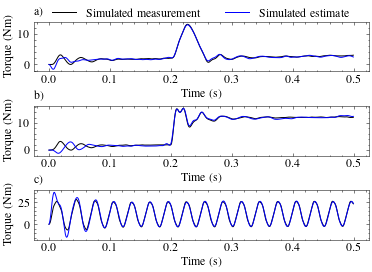

In [60]:
plt.subplot(311)
plt.title("a)", loc='left', fontsize=12)
plt.plot(t_sim_short, yout_sim_imp[:,-1], label="Simulated measurement")
plt.plot(tout_imp_sim, yout_imp_sim[:,-1], '-', c='b', label="Simulated estimate")
#plt.plot(tout_imp_sim_cov, yout_imp_sim_cov[:,-1], '-', c='b', label="HP with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=False, fontsize=12
)

plt.subplot(312)
plt.title("b)", loc='left', fontsize=12)
plt.plot(t_sim_short, yout_sim_step[:,-1], label="Simulated measurement")
plt.plot(tout_step_sim, yout_step_sim[:,-1], '-', c='b', label="Simulated estimate HP")
#plt.plot(tout_step_sim_cov, yout_step_sim_cov[:,-1], '-', c='b', label="HP with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)

plt.subplot(313)
plt.title("c)", loc='left', fontsize=12)
plt.plot(t_sim_short, yout_sim_sin[:,-1], label="Simulated measurement")
plt.plot(tout_sin_sim, yout_sin_sim[:,-1], '-', c='b', label="Simulated estimate HP")
#plt.plot(tout_sin_sim_cov, yout_sin_sim_cov[:,-1], '-', c='b', label="HP with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplots_adjust(hspace=0.7)
plt.savefig("notebook_figures/simulated_unit_responses.eps")

### Unit excitation experiments: input estimation

In [68]:
# NO LOAD
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_no = sensor_data_no[:,1:]
time_no = sensor_data_no[:measurements_no.shape[0],0]
lam_no = lam_hp_imp
estimates_no = ell2_analytical(
    ss, measurements_no[:,:3], batch_size, overlap, time_no, lam=lam_no, use_trend_filter=True
)
estimates_no_cov = ell2_analytical_with_covariance(
    ss, measurements_no[:,:3], batch_size, overlap, time_no, lam=lam_no, use_trend_filter=True
)

Calculating estimates: [█████████████] 13/13

Calculating estimates: [█████████████] 13/13



In [69]:
# IMPULSE
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_imp = sensor_data_imp[:,1:]
time_imp = sensor_data_imp[:measurements_imp.shape[0],0]
lam_imp = lam_hp_imp
estimates_imp = ell2_analytical(
    ss, measurements_imp[:,:3], batch_size, overlap, time_imp, lam=lam_imp, use_trend_filter=True
)
estimates_imp_cov = ell2_analytical_with_covariance(
    ss, measurements_imp[:,:3], batch_size, overlap, time_imp, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [██████████] 10/10

Calculating estimates: [██████████] 10/10



In [70]:
# STEP
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_step = sensor_data_step[:,1:]
time_step = sensor_data_step[:measurements_step.shape[0],0]
lam_step = lam_hp_step
estimates_step = ell2_analytical(
    ss, measurements_step[:,:3], batch_size, overlap, time_step, lam=lam_step, use_trend_filter=True
)
estimates_step_cov = ell2_analytical_with_covariance(
    ss, measurements_step[:,:3], batch_size, overlap, time_step, lam=lam_step, use_trend_filter=True
)

Calculating estimates: [█████████████████████████] 25/25

Calculating estimates: [█████████████████████████] 25/25



In [71]:
# PERIODIC
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sin = sensor_data_sin[:,1:]
time_sin = sensor_data_sin[:measurements_sin.shape[0],0]
lam_sin = lam_hp_sin
estimates_sin = ell2_analytical(
    ss, measurements_sin[:,:3], batch_size, overlap, time_sin, lam=lam_sin, use_trend_filter=True
)
estimates_sin_cov = ell2_analytical_with_covariance(
    ss, measurements_sin[:,:3], batch_size, overlap, time_sin, lam=lam_sin, use_trend_filter=True
)

Calculating estimates: [██████████████████] 18/18

Calculating estimates: [██████████████████] 18/18



### Process and plot unit excitation experiment shaft torque estimates

In [72]:
motor_estimates_no, propeller_estimates_no = process_estimates(len(estimates_no), overlap, estimates_no)
motor_estimates_no_cov, propeller_estimates_no_cov = process_estimates(len(estimates_no_cov), overlap, estimates_no_cov, nstates=0)

In [73]:
# Excitation matrix using estimated input torques
U_est_no = np.hstack((motor_estimates_no, propeller_estimates_no))
U_est_no_cov = np.hstack((motor_estimates_no_cov, propeller_estimates_no_cov))

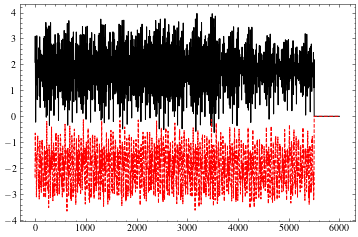

In [74]:
plt.plot(U_est_no_cov[500:,:])

In [75]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_no, yout_no, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_no, t=time_no[:-367])
tout_no_cov, yout_no_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_no_cov, t=time_no[:-367])

Text(0, 0.5, 'Torque (Nm)')

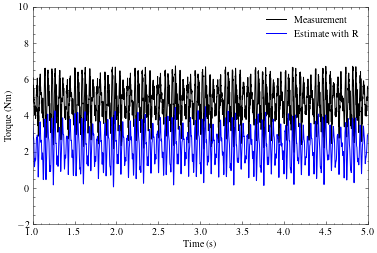

In [76]:
plt.plot(time_no, measurements_no[:,-1], c='black', label="Measurement")
#plt.plot(tout_no, yout_no[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_no_cov, yout_no_cov[:,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlim(1.,5)
plt.ylim(-2,10)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

In [77]:
motor_estimates_imp, propeller_estimates_imp = process_estimates(len(estimates_imp), overlap, estimates_imp)
motor_estimates_imp_cov, propeller_estimates_imp_cov = process_estimates(len(estimates_imp_cov), overlap, estimates_imp_cov, nstates=0)

In [78]:
# Excitation matrix using estimated input torques
U_est_imp = np.hstack((motor_estimates_imp, propeller_estimates_imp))
U_est_imp_cov = np.hstack((motor_estimates_imp_cov, propeller_estimates_imp_cov))

In [79]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_imp, yout_imp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp, t=time_imp[:-234])
tout_imp_cov, yout_imp_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_cov, t=time_imp[:-234])

In [80]:
motor_estimates_step, propeller_estimates_step = process_estimates(len(estimates_step), overlap, estimates_step)
motor_estimates_step_cov, propeller_estimates_step_cov = process_estimates(len(estimates_step_cov), overlap, estimates_step_cov, nstates=0)

In [81]:
# Excitation matrix using estimated input torques
U_est_step = np.hstack((motor_estimates_step, propeller_estimates_step))
U_est_step_cov = np.hstack((motor_estimates_step_cov, propeller_estimates_step_cov))

In [82]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_step, yout_step, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step, t=time_step[:-367])
tout_step_cov, yout_step_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step_cov, t=time_step[:-367])

In [83]:
motor_estimates_sin, propeller_estimates_sin = process_estimates(len(estimates_sin), overlap, estimates_sin)
motor_estimates_sin_cov, propeller_estimates_sin_cov = process_estimates(len(estimates_sin_cov), overlap, estimates_sin_cov, nstates=0)

In [84]:
# Excitation matrix using estimated input torques
U_est_sin = np.hstack((motor_estimates_sin, propeller_estimates_sin))
U_est_sin_cov= np.hstack((motor_estimates_sin_cov, propeller_estimates_sin_cov))

In [85]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_sin, yout_sin, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin, t=time_sin[:-400])
tout_sin_cov, yout_sin_cov, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin_cov, t=time_sin[:-400])

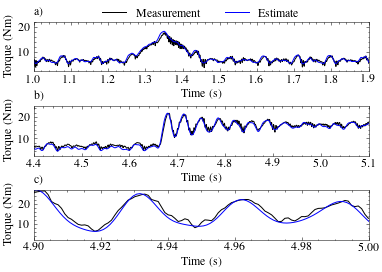

In [86]:
plt.subplot(311)
plt.title("a)", loc='left', fontsize=12)
plt.plot(time_imp, measurements_imp[:,-1], c='black', label="Measurement")
#plt.plot(tout_imp, yout_imp[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_imp_cov, yout_imp_cov[:,-1], '-', c='b', label="Estimate")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=False, fontsize=12
)
plt.xlim(1.,1.9)
plt.ylim(2,22)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(312)
plt.title("b)", loc='left', fontsize=12)
plt.plot(time_step, measurements_step[:,-1], c='black', label="Measurement")
#plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(4.4,5.1)
plt.ylim(2,25)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(313)
plt.title("c)", loc='left', fontsize=12)
plt.plot(time_sin, measurements_sin[:,-1], c='black', label="Measurement")
#plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(4.9,5.)
plt.ylim(2,27)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplots_adjust(hspace=0.7)
plt.savefig("notebook_figures/unit_experiment_hp_using_R.eps")

### L-curve comparison simulation vs measurement

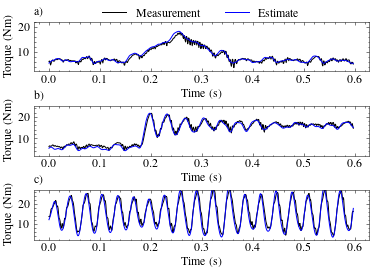

In [87]:
# Here a 600 timstep section is extracted for calculating the L-curve using testbench measurements
plt.subplot(311)
plt.title("a)", loc='left', fontsize=12)
plt.plot(time_imp[:600], measurements_imp[1100:1700,-1], c='black', label="Measurement")
#plt.plot(tout_imp, yout_imp[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_imp_cov[:600], yout_imp_cov[1100:1700,-1], '-', c='b', label="Estimate")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=False, fontsize=12
)
#plt.xlim(1.,1.9)
plt.ylim(2,22)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(312)
plt.title("b)", loc='left', fontsize=12)
plt.plot(time_step[:600], measurements_step[4500:5100,-1], c='black', label="Measurement")
#plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_step[:600], yout_step[4500:5100,-1], '-', c='b', label="Estimate with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.xlim(4.4,5.1)
plt.ylim(2,25)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplot(313)
plt.title("c)", loc='left', fontsize=12)
plt.plot(time_sin[:600], measurements_sin[5000:5600,-1], c='black', label="Measurement")
#plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_sin[:600], yout_sin[5000:5600,-1], '-', c='b', label="Estimate with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.xlim(4.9,5.)
plt.ylim(2,27)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.subplots_adjust(hspace=0.7)

In [88]:
def calculate_L_curve_with_measurements(times, dt, measurements, lambdas, use_trend=False, show_plot=False):

    A, B, C, D = get_testbench_state_space(dt)
    sys = (A, B, C, D)
    l_norm, residual_norm, input_estimates = L_curve(
        sys,
        measurements,
        times,
        lambdas,
        use_trend=use_trend
    )

    plt.plot(input_estimates[6][51::2])
    plt.show()
    
    if show_plot:
        plt.figure(figsize=(6,4))
        plt.yscale("log")
        plt.xscale("log")
        plt.plot(residual_norm, l_norm, color='blue')
        plt.scatter(residual_norm, l_norm, color='blue')
        plt.xlabel("Residual norm $||y-\Gamma u||_2$", fontsize=12)
        plt.ylabel("Regularising norm $||L u||_2$", fontsize=12)
        plt.annotate(
            "$\lambda = $" + str(lambdas[6]),
            (residual_norm[6], l_norm[6]),
            (residual_norm[6]-0.5, l_norm[6]-0.1)
        )
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        plt.show()

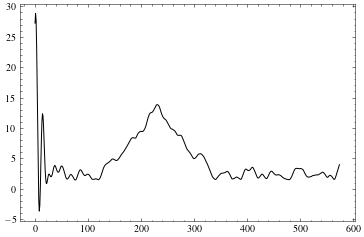

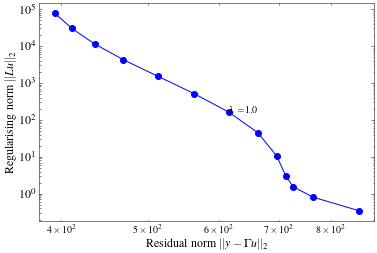

In [89]:
calculate_L_curve_with_measurements(
    time_imp[:600], 
    np.mean(np.diff(time_imp)), 
    measurements_imp[1100:1700,:-1], 
    regularization_parameters, 
    use_trend=True, 
    show_plot=True
)

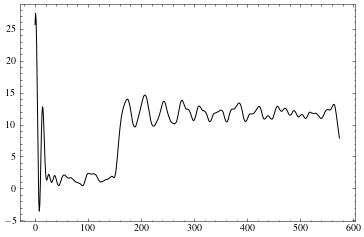

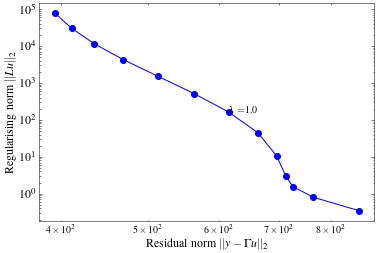

In [90]:
calculate_L_curve_with_measurements(
    time_step[:600],
    np.mean(np.diff(time_step)),
    measurements_step[4500:5100,:-1],
    regularization_parameters,
    use_trend=True,
    show_plot=True
)

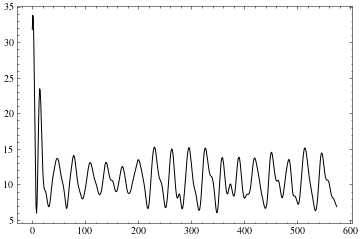

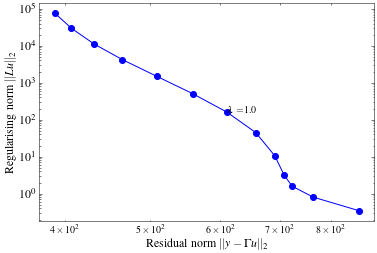

In [91]:
calculate_L_curve_with_measurements(
    time_sin[:600],
    np.mean(np.diff(time_sin)),
    measurements_sin[5000:5600,:-1],
    regularization_parameters,
    use_trend=True,
    show_plot=True
)

### Ice excitation experiment: input estimation

In [92]:
# call the estimation function
times = time[:measurements.shape[0]]
lam = lam_hp_ice
estimates_ice = ell2_analytical(
    ss, measurements[:,:3], batch_size, overlap, times, lam=lam, use_trend_filter=True
)
estimates_ice_cov = ell2_analytical_with_covariance(
    ss, measurements[:,:3], batch_size, overlap, times, lam=lam, use_trend_filter=True
)

Calculating estimates: [████████████████████] 20/20

Calculating estimates: [████████████████████] 20/20



### Process and plot ice excitation experiment shaft torque estimates

In [93]:
motor_estimates_ice, propeller_estimates_ice = process_estimates(len(estimates_ice), overlap, estimates_ice)
motor_estimates_ice_cov, propeller_estimates_ice_cov = process_estimates(len(estimates_ice_cov), overlap, estimates_ice_cov, nstates=0)

In [94]:
# Excitation matrix using estimated input torques
U_est = np.hstack((motor_estimates_ice, propeller_estimates_ice))
U_est_cov = np.hstack((motor_estimates_ice_cov, propeller_estimates_ice_cov))

In [95]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout, yout, xout = dlsim((A, B, C_mod, D_mod, dt), U_est, t=times[:-67])
tout_cov, yout_cov, xout_cov = dlsim((A, B, C_mod, D_mod, dt), U_est_cov, t=times[:-67])

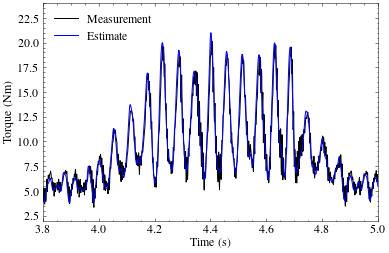

In [96]:
# plt.title("Torque sensor 2")
plt.plot(times, measurements[:,-1], c='black', label="Measurement")
#plt.plot(tout, yout[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_cov, yout_cov[:,-1], '-', c='b', label="Estimate")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(3.8,5.)
plt.ylim(2,24)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.savefig("notebook_figures/ice_experiment_hp_using_R.eps")

### Test ice experiment with different lambda

In [97]:
estimates_ice_cov2 = ell2_analytical_with_covariance(
    ss, measurements[:,:3], batch_size, overlap, times, lam=0.01, use_trend_filter=True
)
estimates_ice_cov22 = ell2_analytical_with_covariance(
    ss, measurements[:,:3], batch_size, overlap, times, lam=0.01, use_trend_filter=True
)

Calculating estimates: [████████████████████] 20/20

Calculating estimates: [████████████████████] 20/20



In [98]:
motor_estimates_ice_cov2, propeller_estimates_ice_cov2 = process_estimates(len(estimates_ice_cov2), overlap, estimates_ice_cov2, nstates=0)
motor_estimates_ice_cov22, propeller_estimates_ice_cov22 = process_estimates(len(estimates_ice_cov22), overlap, estimates_ice_cov22, nstates=0)

In [99]:
U_est_cov2 = np.hstack((motor_estimates_ice_cov2, propeller_estimates_ice_cov2))
U_est_cov22 = np.hstack((motor_estimates_ice_cov22, propeller_estimates_ice_cov22))

In [100]:
tout_cov2, yout_cov2, xout_cov2 = dlsim((A, B, C_mod, D_mod, dt), U_est_cov2, t=times[:-67])
tout_cov22, yout_cov22, xout_cov22 = dlsim((A, B, C_mod, D_mod, dt), U_est_cov22, t=times[:-67])

Text(0, 0.5, 'Torque (Nm)')

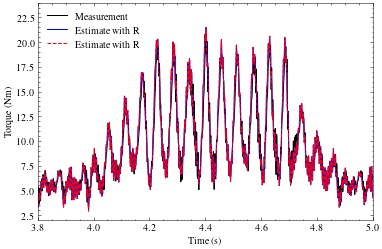

In [101]:
plt.plot(times, measurements[:,-1], c='black', label="Measurement")
#plt.plot(tout, yout[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_cov2, yout_cov2[:,-1], '-', c='b', label="Estimate with R")
plt.plot(tout_cov22, yout_cov22[:,-1], '--', c='r', label="Estimate with R")

plt.legend()
plt.xlim(3.8,5.)
plt.ylim(2,24)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

## RMS errors

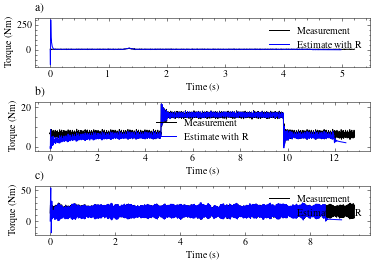

In [102]:
plt.subplot(311)
plt.title("a)", loc='left')
plt.plot(time_imp, measurements_imp[:,-1], c='black', label="Measurement")
#plt.plot(tout_imp, yout_imp[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_imp_cov, yout_imp_cov[:,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

plt.subplot(312)
plt.title("b)", loc='left')
plt.plot(time_step, measurements_step[:,-1], c='black', label="Measurement")
#plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

plt.subplot(313)
plt.title("c)", loc='left')
plt.plot(time_sin, measurements_sin[:,-1], c='black', label="Measurement")
#plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate")
plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplots_adjust(hspace=0.7)

Mean absloute error:  0.4837884628784687
Root mean square error: 0.609185032779585


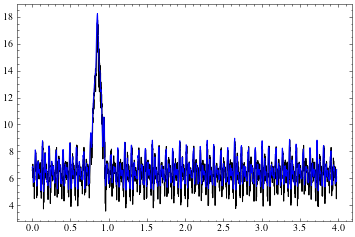

In [103]:
plt.plot(time_imp[:-1235], measurements_imp[500:-735,-1], c='black', label="Measurement")
plt.plot(tout_imp_cov[:-1000], yout_imp_cov[500:-500,-1], '-', c='b', label="Estimate with R")
mae_imp = np.mean(np.abs(yout_imp_cov[500:-500,-1]-measurements_imp[500:-735,-1]))
print("Mean absloute error: ", mae_imp)
rmse_imp = np.sqrt(np.mean(np.square(yout_imp_cov[500:-500,-1]-measurements_imp[500:-735,-1])))
print("Root mean square error:", rmse_imp)

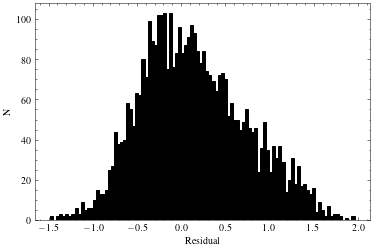

In [104]:
residual_imp = yout_imp_cov[500:-500,-1]-measurements_imp[500:-735,-1]
plt.hist(residual_imp, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Residual')
plt.ylabel('N')
plt.show()

Mean absloute error:  0.4837884628784687
Root mean square error: 0.771992273584651


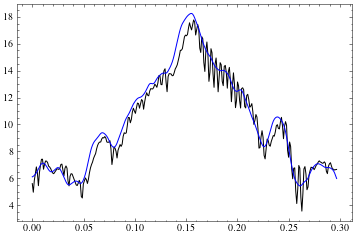

In [105]:
plt.plot(time_imp[:-4935], measurements_imp[1200:-3735,-1], c='black', label="Measurement")
plt.plot(tout_imp_cov[:-4700], yout_imp_cov[1200:-3500,-1], '-', c='b', label="Estimate with R")
mae_imp2 = np.mean(np.abs(yout_imp_cov[1200:-3500,-1]-measurements_imp[1200:-3735,-1]))
print("Mean absloute error: ", mae_imp)
rmse_imp2 = np.sqrt(np.mean(np.square(yout_imp_cov[1200:-3500,-1]-measurements_imp[1200:-3735,-1])))
print("Root mean square error:", rmse_imp2)

Mean absloute error:  0.6339836828188112
Root mean square error: 0.7743024700062905


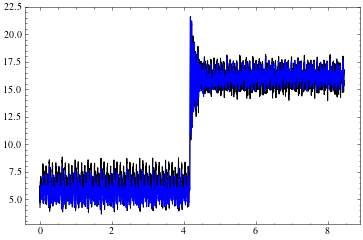

In [106]:
plt.plot(time_step[:-4368], measurements_step[500:-3868,-1], c='black', label="Measurement")
plt.plot(tout_step_cov[:-4000], yout_step_cov[500:-3500,-1], '-', c='b', label="Estimate with R")
mae_step = np.mean(np.abs(yout_step_cov[500:-3500,-1]-measurements_step[500:-3868,-1]))
print("Mean absloute error: ", mae_step)
rmse_step = np.sqrt(np.mean(np.square(yout_step_cov[500:-3500,-1]-measurements_step[500:-3868,-1])))
print("Root mean square error:", rmse_step)

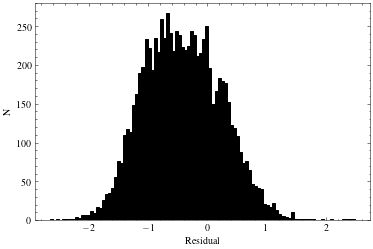

In [107]:
residual_step = yout_step_cov[500:-3500,-1]-measurements_step[500:-3868,-1]
plt.hist(residual_step, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Residual')
plt.ylabel('N')
plt.show()

Mean absloute error:  1.5379306105096815
Root mean square error: 1.8625912920562282


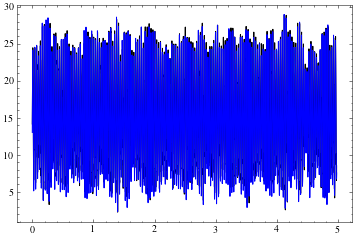

In [108]:
plt.plot(time_sin[:-4401], measurements_sin[500:-3901,-1], c='black', label="Measurement")
plt.plot(tout_sin_cov[:-4000], yout_sin_cov[500:-3500,-1], '-', c='b', label="Estimate with R")
mae_sin = np.mean(np.abs(yout_sin_cov[500:-3500,-1]-measurements_sin[500:-3901,-1]))
print("Mean absloute error: ", mae_sin)
rmse_sin = np.sqrt(np.mean(np.square(yout_sin_cov[500:-3500,-1]-measurements_sin[500:-3901,-1])))
print("Root mean square error:", rmse_sin)

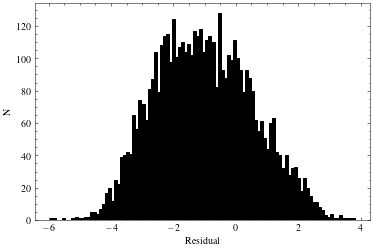

In [109]:
residual_sin = yout_sin_cov[500:-3500,-1]-measurements_sin[500:-3901,-1]
plt.hist(residual_sin, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Residual')
plt.ylabel('N')
plt.show()

Mean absloute error:  0.6543723365289359
Root mean square error: 0.8417975839497192


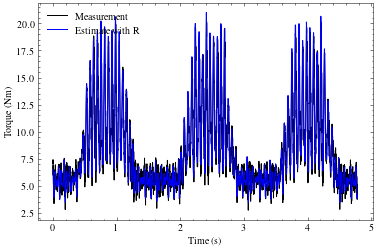

In [110]:
dlt = len(times)-len(tout_cov)  # difference in the length of the time vectors of the measurement and estimate
cl = 2000  # cut left side of data
cr = 3200  # cut right side of data
crd = cr + dlt  # cut right side of data including dlt
t_cut = cl + cr
t_cutd = cl + crd

plt.plot(times[:-t_cutd], measurements[cl:-crd,-1], c='black', label="Measurement")
plt.plot(tout_cov[:-t_cut], yout_cov[cl:-cr,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

mae_ice = np.mean(np.abs(yout_cov[cl:-cr,-1]-measurements[cl:-crd,-1]))
print("Mean absloute error: ", mae_ice)
rmse_ice = np.sqrt(np.mean(np.square(yout_cov[cl:-cr,-1]-measurements[cl:-crd,-1])))
print("Root mean square error:", rmse_ice)

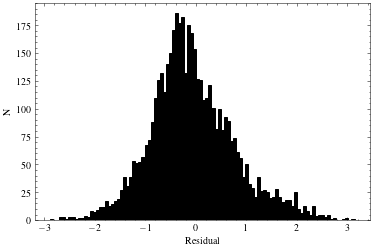

In [111]:
residual_ice = yout_cov[cl:-cr,-1]-measurements[cl:-crd,-1]
plt.hist(residual_ice, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Residual')
plt.ylabel('N')
plt.show()

Mean absloute error:  0.7073287582335657
Root mean square error 0.8930824147098426


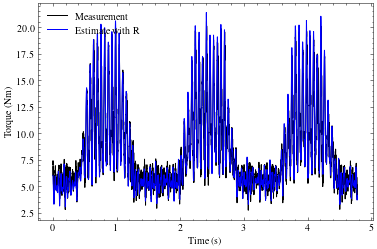

In [112]:
plt.plot(times[:-t_cutd], measurements[cl:-crd,-1], c='black', label="Measurement")
plt.plot(tout[:-t_cut], yout[cl:-cr,-1], '-', c='b', label="Estimate with R")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

mae_ice2 = np.mean(np.abs(yout[cl:-cr,-1]-measurements[cl:-crd,-1]))
print("Mean absloute error: ", mae_ice2)
rmse_ice2 = np.sqrt(np.mean(np.square(yout[cl:-cr,-1]-measurements[cl:-crd,-1])))
print("Root mean square error", rmse_ice2)

([<matplotlib.axis.XTick at 0x7fd796dc9d60>,
 [Text(1, 0, 'Impulse'),
  Text(2, 0, 'Step'),
  Text(3, 0, 'Periodic'),
  Text(4, 0, 'Ice'),
  Text(5, 0, 'Ice w/o R')])

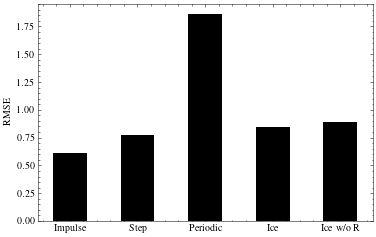

In [113]:
plt.bar([1, 2, 3, 4, 5], [rmse_imp, rmse_step, rmse_sin, rmse_ice, rmse_ice2], width=0.5, color='black')
plt.ylabel("RMSE")
plt.xticks([1, 2, 3, 4, 5], ["Impulse", "Step", "Periodic", "Ice", "Ice w/o R"])

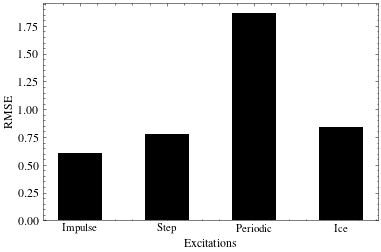

In [114]:
plt.bar([1, 2, 3, 4], [rmse_imp, rmse_step, rmse_sin, rmse_ice], width=0.5, color='black')
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Excitations", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
plt.xticks([1, 2, 3, 4], ["Impulse", "Step", "Periodic", "Ice"])
plt.savefig("notebook_figures/RMSE_barplot.eps")

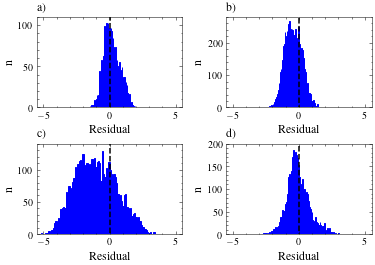

In [135]:
plt.subplot(221)
plt.title("a)", loc='left', fontsize=12)
plt.hist(residual_imp, bins=100, color='b', edgecolor='b')  # Adjust the number of bins as needed
plt.plot([0,0], [-10,110], '--', c='black', linewidth=1.5)
plt.xlabel('Residual', fontsize=12)
plt.ylabel('n', fontsize=12)
plt.xlim(-5.5,5.5)
plt.ylim(0,110)
plt.subplot(222)
plt.title("b)", loc='left', fontsize=12)
plt.hist(residual_step, bins=100, color='b', edgecolor='b')  # Adjust the number of bins as needed
plt.plot([0,0], [-10,300], '--', c='black', linewidth=1.5)
plt.xlabel('Residual', fontsize=12)
plt.ylabel('n', fontsize=12)
plt.xlim(-5.5,5.5)
plt.ylim(0,280)
plt.subplot(223)
plt.title("c)", loc='left', fontsize=12)
plt.hist(residual_sin, bins=100, color='b', edgecolor='b')  # Adjust the number of bins as needed
plt.plot([0,0], [-10,300], '--', c='black', linewidth=1.5)
plt.xlabel('Residual', fontsize=12)
plt.ylabel('n', fontsize=12)
plt.xlim(-5.5,5.5)
plt.ylim(0,140)
plt.subplot(224)
plt.title("d)", loc='left', fontsize=12)
plt.hist(residual_ice, bins=100, color='b', edgecolor='b')  # Adjust the number of bins as needed
plt.plot([0,0], [-10,300], '--', c='black', linewidth=1.5)
plt.xlabel('Residual', fontsize=12)
plt.ylabel(r'\text{n}', fontsize=12)
plt.xlim(-5.5,5.5)
plt.ylim(0,200)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
plt.savefig("notebook_figures/residual_histogram.eps")
plt.show()